In [1]:
from flopa.io.ptuio.decoder import T3OverflowCorrector
from flopa.io.ptuio.reader import TTTRReader
from flopa.io.ptuio.reconstructor import ScanConfig, ImageReconstructor
from flopa.io.ptuio.utils import estimate_tcspc_bins, smooth_weighted, create_FLIM_image, draw_unitary_circle

import matplotlib.pyplot as plt

import numpy as np



In [2]:
reader = TTTRReader('../tests/data/LSM/LSM_512x_modi_f1_accu4.ptu')
cfg = ScanConfig(
        bidirectional=False,
        frames=1,
        pixels=512,
        lines=512,
        line_accumulations=(4,),
        max_detector=2
)


In [3]:


# Get some constants from the header
wrap = reader.header.tags.get("TTResultFormat_WrapAround", 1024)  # default fallback
repetition_rate = reader.header.tags.get("TTResult_SyncRate",40e6)  
tcspc_resolution = reader.header.tags.get("MeasDesc_Resolution",5e-12)
tcspc_bins = estimate_tcspc_bins(reader.header.tags,buffer=0)



In [4]:

corrector = T3OverflowCorrector(wraparound=wrap)
reconstructor = ImageReconstructor(
    config=cfg, 
    tcspc_channels= tcspc_bins,
    # outputs=['tcspc_histogram'],
    
    )


for chunk in reader.iter_chunks():
    
    corrected_chunk = corrector.correct(chunk)
    reconstructor.update(corrected_chunk)

result = reconstructor.finalize()

print(result.coords)

TCSPC channel overflow detected! Max channel: 26732
Channel overflow detected! Max channel: 53
TCSPC channel overflow detected! Max channel: 750
TCSPC channel overflow detected! Max channel: 762
Coordinates:
  * frame          (frame) uint32 4B 0
  * sequence       (sequence) uint8 1B 0
  * line           (line) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * pixel          (pixel) uint32 2kB 0 1 2 3 4 5 6 ... 506 507 508 509 510 511
  * detector       (detector) uint8 2B 0 1
  * tcspc_channel  (tcspc_channel) uint16 782B 0 1 2 3 4 ... 386 387 388 389 390


Get results and convert slices to numpy

In [5]:
intensity = result.photon_count.isel(frame=0,sequence=0,detector=0).values
lifetime = result.mean_arrival_time.isel(frame=0,sequence=0,detector=0).values
g = result.phasor_g.isel(frame=0,sequence=0,detector=0).values
s = result.phasor_s.isel(frame=0,sequence=0,detector=0).values



Smooth arrays

In [6]:
smooth_size = 4 
lifetime_smoothed, intensity_smoothed = smooth_weighted(lifetime, intensity, size=smooth_size) # smooth intensity is needed to weight-smooth lifetime, so why not return both
g_smoothed, _ = smooth_weighted(g,intensity,size=smooth_size)
s_moothed, _ = smooth_weighted(s, intensity,size=smooth_size)

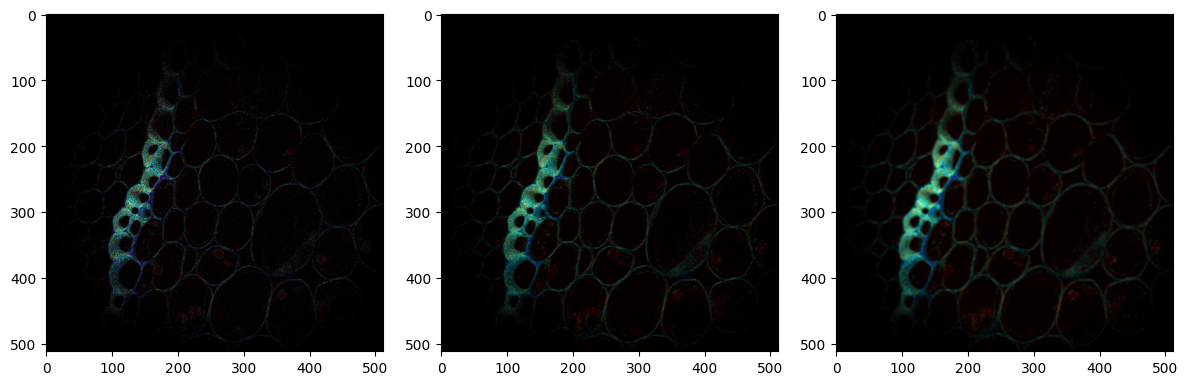

In [7]:

FLIM = create_FLIM_image(
    lifetime * tcspc_resolution * 1e9,
    intensity,
    lt_min=1, lt_max=3,

)

FLIM_smoothed = create_FLIM_image(
    lifetime_smoothed * tcspc_resolution * 1e9,
    intensity,
    lt_min=1, lt_max=3

)

both_smoothed = create_FLIM_image(
    lifetime_smoothed * tcspc_resolution * 1e9,
    intensity_smoothed,
    lt_min=1, lt_max=3

)

fig, ax = plt.subplots(1,3, figsize = (12,4))
ax[0].imshow(FLIM)
ax[1].imshow(FLIM_smoothed)
ax[2].imshow(both_smoothed)

plt.tight_layout()
plt.show()
# I would leave both options independently - smooth intensity and/or lifetime

Smoothing changes lifetime histogram - update that as well

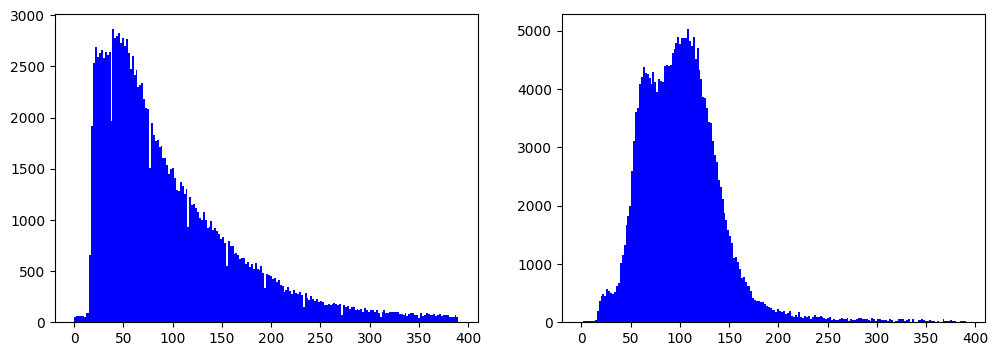

In [8]:
fig, ax = plt.subplots(1,2, figsize =(12,4))
ax[0].hist(lifetime.ravel(),bins = 200,color='b')
ax[1].hist(lifetime_smoothed.ravel(),bins = 200,color='b')
plt.show()

Intensity histogram as well, of course

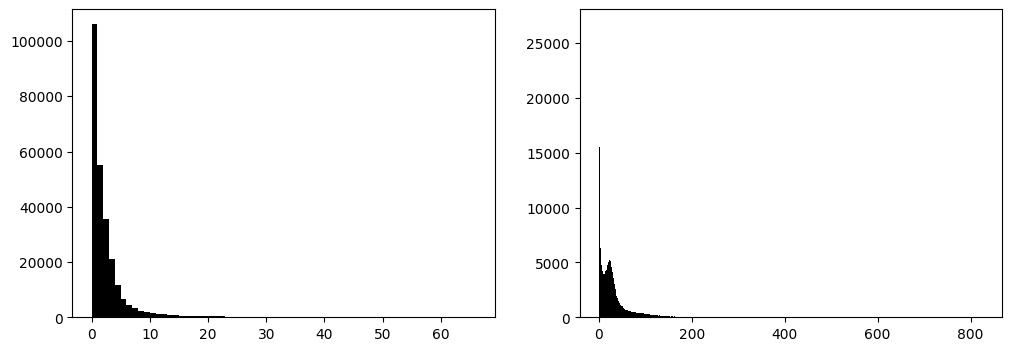

In [9]:
fig, ax = plt.subplots(1,2, figsize =(12,4))
ax[0].hist(intensity.ravel(),bins = np.max(intensity),color='k')
ax[1].hist(intensity_smoothed.ravel(),bins = np.max(intensity_smoothed),color='k')
plt.show()

Now what does smoothing do to the phasor plot

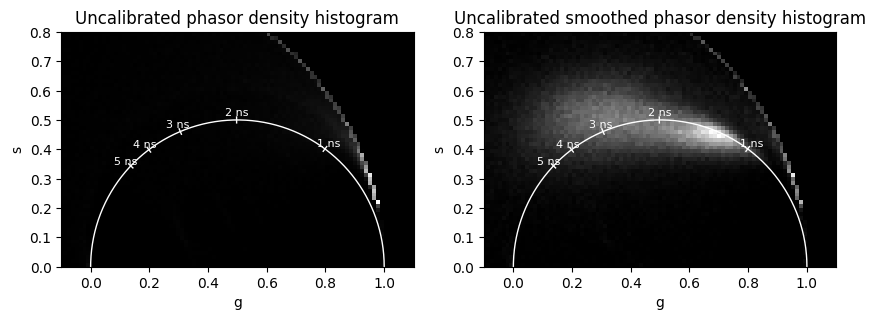

In [10]:
phasor = np.array(g + 1j * s).astype(np.complex64)
phasor_smoothed = np.array(g_smoothed + 1j * s_moothed).astype(np.complex64)

valid = np.isfinite(phasor) & (intensity > 0)
valid_smoothed = np.isfinite(phasor_smoothed) & (intensity_smoothed > 0)

H, xedges, yedges = np.histogram2d(g[valid].ravel(), s[valid].ravel(), bins=150)
H_smoothed, xedges_smoothed, yedges_smoothed = np.histogram2d(g_smoothed[valid_smoothed].ravel(), s_moothed[valid_smoothed].ravel(), bins=150)


fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(H.T, origin='lower',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='gray', aspect='equal')
ax[0].set_xlabel('g')
ax[0].set_ylabel('s')
ax[0].set_title('Uncalibrated phasor density histogram')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
ax[0].set_facecolor('black')
draw_unitary_circle(ax[0], sync_rate=repetition_rate, tau_max = 5)

ax[1].imshow(H_smoothed.T, origin='lower',
          extent=[xedges_smoothed[0], xedges_smoothed[-1], yedges_smoothed[0], yedges_smoothed[-1]],
          cmap='gray', aspect='equal')
ax[1].set_xlabel('g')
ax[1].set_ylabel('s')
ax[1].set_title('Uncalibrated smoothed phasor density histogram')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[1].set_facecolor('black')
draw_unitary_circle(ax[1], sync_rate=repetition_rate, tau_max = 5)




# ax.plot(phasor_measured.real,phasor_measured.imag,"rs")
plt.show()
